## This file consists of the following code segments:
### 1. Featurization and loading of data
### 2. Neural Network implmentations (For 5 different cases)
### 3. KNN implmentation for individual transition metal suphides and comparision (Disparity Plot)
### 4. Neural Net implmentation for individual transition metal suphides and comparision (Disparity Plot)

## 1. Featurization function 

### Processing of Preprocessed data - creating using gaussian distribution from file DataPreProcessing


In [1]:
from ase.io import read,write
import pymatgen
from pymatgen.analysis.local_env import VoronoiNN
from scipy.spatial import Voronoi, SphericalVoronoi
from pymatgen.io.ase import AseAtomsAdaptor
import os
import pickle
import uuid
import json
from collections import OrderedDict, Iterable, Mapping
from multiprocess import Pool
import numpy as np
import gc
import tqdm
import ase.io
from ase import Atoms
from ase.constraints import FixAtoms
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.local_env import VoronoiNN
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
import numpy as np
from numpy import genfromtxt
from os import listdir
import time 
import pandas as pd
import random
import torch
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from torch.autograd import Variable

def fingerprint_atoms_2(atoms):
    '''
    This function is used to fingerprint an adslabs atoms object, where the "fingerprint" is a
    dictionary of properties that we believe may be adsorption motifs.
    Inputs:
        atoms   Atoms object to fingerprint. The slab atoms must be tagged with 0 and
                adsorbate atoms must be tagged with non-zero integers. This function also
                assumes that the first atom in each adsorbate is the binding atom (e.g.,
                of all atoms with tag==1, the first atom is the binding; the same goes for
                tag==2 and tag==3 etc.).
    '''
#     # Remove the adsorbate(s) while finding the binding position(s)
#     atoms, binding_positions = remove_adsorbate(atoms)
#     # Add Uranium atoms at each of the binding sites so that we can use them for fingerprinting.
#     for tag in binding_positions:
#         atoms += Atoms('U', positions=[binding_positions[tag]])

    # Turn the atoms into a pymatgen structure object so that we can use the VCF to find
    # the coordinated sites.
    struct = AseAtomsAdaptor.get_structure(atoms)

    #Test to see if the central atom is entirely on it's own, if so it is not coordinated, so skip the voronoi bit
    # which would throw a QHULL error
    num_cutoff_neighbors = [site[0] for site in enumerate(struct) if 0.1 < struct[len(atoms)-1].distance(site[1]) < 7.0]
    if len(num_cutoff_neighbors) == 0:
        return {'coordination': '',
                'neighborcoord': '',
                'natoms': len(atoms),
                'nextnearestcoordination': ''}

    vnn = VoronoiNN(allow_pathological=True, tol=0.8, cutoff=10)
    vnn_loose = VoronoiNN(allow_pathological=True, tol=0.2, cutoff=10)
    try:
        coordinated_atoms_data = vnn.get_nn_info(struct, len(atoms)-1)
    except ValueError:
        vnn = VoronoiNN(allow_pathological=True, tol=0.8, cutoff=40)
        vnn_loose = VoronoiNN(allow_pathological=True, tol=0.2, cutoff=40)
        coordinated_atoms_data = vnn.get_nn_info(struct, len(atoms)-1)
    coordinated_atoms = [atom_data['site'] for atom_data in coordinated_atoms_data]
    # Create a list of symbols of the coordinations, remove uranium from the list, and
    # then turn the list into a single, human-readable string.
    coordinated_symbols = map(lambda x: x.species_string, coordinated_atoms)
    coordinated_symbols = [a for a in coordinated_symbols if a not in ['U']]
    coordination = '-'.join(sorted(coordinated_symbols))

    # Make a [list] of human-readable coordination sites [unicode] for all of the slab atoms
    # that are coordinated to the adsorbate, "neighborcoord"
    neighborcoord = []
    for i in coordinated_atoms:
        # [int] that yields the slab+ads system's atomic index for the 1st-tier-coordinated atom
        neighborind = [site[0] for site in enumerate(struct) if i.distance(site[1]) < 0.1][0]
        # [list] of PyMatGen [periodic site class]es for each of the atoms that are coordinated
        # with the adsorbate
        coord_data = vnn_loose.get_nn_info(struct, neighborind)
        coord = [atom_data['site'] for atom_data in coord_data]
        # The elemental symbols for all of the 2nd-tier-coordinated atoms in a [list] of
        # [unicode] objects
        coord_symbols = map(lambda x: x.species_string, coord)
        # Take out atoms that we assume are not part of the slab
        coord_symbols = [a for a in coord_symbols if a not in ['U']]
        # Sort the list of 2nd-tier-coordinated atoms to induce consistency
        coord_symbols.sort()
        # Turn the [list] of [unicode] values into a single [unicode]
        neighborcoord.append(i.species_string+':'+'-'.join(coord_symbols))

    # [list] of PyMatGen [periodic site class]es for each of the atoms that are
    # coordinated with the adsorbate
    coordinated_atoms_nextnearest_data = vnn_loose.get_nn_info(struct, len(atoms)-1)
    coordinated_atoms_nextnearest = [atom_data['site'] for atom_data in coordinated_atoms_nextnearest_data]
    # The elemental symbols for all of the coordinated atoms in a [list] of [unicode] objects
    coordinated_symbols_nextnearest = map(lambda x: x.species_string,
                                          coordinated_atoms_nextnearest)
    # Take out atoms that we assume are not part of the slab
    coordinated_symbols_nextnearest = [a for a in coordinated_symbols_nextnearest
                                       if a not in ['U']]
    # Turn the [list] of [unicode] values into a single [unicode]
    coordination_nextnearest = '-'.join(sorted(coordinated_symbols_nextnearest))

    # Return a dictionary with each of the fingerprints. Any key/value pair can be added here
    # and will propagate up the chain
    return {'coordination': coordination,
            'neighborcoord': neighborcoord,
            'natoms': len(atoms),
            'nextnearestcoordination': coordination_nextnearest}

def nearest_neighbor_count(neighbors,atom_type):
#Takes neighbors as a dictionary object and the atom type whose coordination number
#we are interested in 
#The neighbor object is within a cut off radius of 7 Angstrom
    C=neighbors['coordination']    
    return C.count(atom_type)

def next_nearest_neighbor_count(neighbors,atom_type):
#Takes neighbors as a dictionary object and the atom type whose coordination number
#we are interested in 
#The neighbor object is within a cut off radius of 7 Angstrom
    N=neighbors['neighborcoord']
    NN=neighbors['nextnearestcoordination']
    N_count=0
    for i in range(len(N)):
        s=N[i]
        sub_s=s[s.index(':') + len(':'):]
        N_count+=sub_s.count(atom_type)
    return N_count

# Create Gaussian distributions and write to xlsx
def ret_Gaussian(mu,sigma,N):
    s = np.random.normal(mu, sigma, N)
    return s


def featurize_new(atoms):
    a=fingerprint_atoms_2(atoms)
    C=a['coordination']
    N=a['neighborcoord']
    NN=a['nextnearestcoordination']
    neighbor_types=['S','Co', 'Ti', 'Cu', 'Mn', 'Mo', 'V', 'Ru', 'Sc']
    atom_number=np.array([16,27,22,29,25,42,23,44,21])
    chi=np.array([2.58,1.88,1.54,1.92,1.90,1.55,2.16,1.63,2.2,1.36])

    std_GOH = np.array([0.17,0.19,0.16,0.20,0.21,0.21,0.15,0.12,0.13])
    feature_vec=np.zeros((3,2*len(neighbor_types)))
    for i in range(len(neighbor_types)):
        if nearest_neighbor_count(a,neighbor_types[i])!=0:
            feature_vec[:,i]=(np.array([atom_number[i],chi[i],nearest_neighbor_count(a,neighbor_types[i])])).T
        else:
            feature_vec[:,i]=(np.array([0,0,0])).T
    for i in range(len(neighbor_types)):
        if next_nearest_neighbor_count(a,neighbor_types[i])!=0:
            feature_vec[:,i+len(neighbor_types)]=(np.array([atom_number[i],chi[i],next_nearest_neighbor_count(a,neighbor_types[i])])).T
        else:
            feature_vec[:,i+len(neighbor_types)]=(np.array([0,0,0])).T

    return feature_vec


## Loading data saved in location swapped_data_for_featurizing
### Loading the .xls containing the 'y' vector (gibbs free energy)  and creating gaussian distribution of the data

In [2]:
## Big Data
## Fetching DGOH data all sulfide classes

import numpy as np
from numpy import genfromtxt
from os import listdir
import time 
import pandas as pd
import random
import torch
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from torch.autograd import Variable
comp = ['CoS','CuS','MnS','MoS','RuS','ScS','TiS','VS']


####################################################
#loading all file names 
def find_xyz_filenames( path_to_dir, suffix=".xyz" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

path='swapped_data_for_featurizing'
CoS_filenames = find_xyz_filenames(path+'/CoS')
CuS_filenames = find_xyz_filenames(path+'/CuS')
MnS_filenames = find_xyz_filenames(path+'/MnS')
MoS_filenames = find_xyz_filenames(path+'/MoS')
RuS_filenames = find_xyz_filenames(path+'/RuS')
ScS_filenames = find_xyz_filenames(path+'/ScS')
TiS_filenames = find_xyz_filenames(path+'/TiS')
VS_filenames = find_xyz_filenames(path+'/VS')


#####################################################
#loading the excel file
def find_xlsx_filenames( path_to_dir, suffix=".xlsx" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

xlsx_filenames = find_xlsx_filenames('data')



######################################################
#loading xlsx data
path ='data/'+xlsx_filenames[0]

##reading the data from each sheet
df = pd.read_excel(path,sheet_name=0)
delta_g_CoS = df[df.columns[0]]
ads_CoS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=1)
delta_g_CuS = df[df.columns[0]]
ads_CuS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=2)
delta_g_MnS = df[df.columns[0]]
ads_MnS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=3)
delta_g_TiS = df[df.columns[0]]
ads_TiS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=4)
delta_g_RuS = df[df.columns[0]]
ads_RuS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=5)
delta_g_MoS = df[df.columns[0]]
ads_MoS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=6)
delta_g_ScS = df[df.columns[0]]
ads_ScS = df[df.columns[1]]


df = pd.read_excel(path,sheet_name=7)
delta_g_VS = df[df.columns[0]]
ads_VS = df[df.columns[1]]

#creating gaussian distribution similar to DFT study data

std_GOH = np.array([0.17,0.19,0.16,0.20,0.21,0.21,0.15,0.12,0.13])

N=30
j=0
vec_Co=np.zeros((len(delta_g_CoS),N))
for i in range(len(delta_g_CoS)):
    vec_Co[i,:]=(ret_Gaussian(delta_g_CoS[i],std_GOH[j],N)).T
j=j+1

vec_Cu=np.zeros((len(delta_g_CuS),N))
for i in range(len(delta_g_CuS)):
    vec_Cu[i,:]=ret_Gaussian(delta_g_CuS[i],std_GOH[j],N)
j=j+1

vec_Mn=np.zeros((len(delta_g_MnS),N))
for i in range(len(delta_g_MnS)):
    vec_Mn[i,:]=ret_Gaussian(delta_g_MnS[i],std_GOH[j],N)
j=j+1

vec_Ti=np.zeros((len(delta_g_TiS),N))
for i in range(len(delta_g_TiS)):
    vec_Ti[i,:]=ret_Gaussian(delta_g_TiS[i],std_GOH[j],N)
j=j+1

vec_Ru=np.zeros((len(delta_g_RuS),N))
for i in range(len(delta_g_RuS)):
    vec_Ru[i,:]=ret_Gaussian(delta_g_RuS[i],std_GOH[j],N)
j=j+1

vec_Mo=np.zeros((len(delta_g_MoS),N))
for i in range(len(delta_g_MoS)):
    vec_Mo[i,:]=ret_Gaussian(delta_g_MoS[i],std_GOH[j],N)
j=j+1

vec_Sc=np.zeros((len(delta_g_ScS),N))
for i in range(len(delta_g_ScS)):
    vec_Sc[i,:]=ret_Gaussian(delta_g_ScS[i],std_GOH[j],N)
j=j+1

vec_V=np.zeros((len(delta_g_VS),N))
for i in range(len(delta_g_VS)):
    vec_V[i,:]=ret_Gaussian(delta_g_VS[i],std_GOH[j],N)
j=j+1

vec_Co_reshape=np.reshape(vec_Co.T,(vec_Co.T.size,1))
vec_Cu_reshape=np.reshape(vec_Cu.T,(vec_Cu.T.size,1))
vec_Mn_reshape=np.reshape(vec_Mn.T,(vec_Mn.T.size,1))
vec_Ti_reshape=np.reshape(vec_Ti.T,(vec_Ti.T.size,1))
vec_Ru_reshape=np.reshape(vec_Ru.T,(vec_Ru.T.size,1))
vec_Mo_reshape=np.reshape(vec_Mo.T,(vec_Mo.T.size,1))
vec_Sc_reshape=np.reshape(vec_Sc.T,(vec_Sc.T.size,1))
vec_V_reshape=np.reshape(vec_V.T,(vec_V.T.size,1))
                         
                          
DGOH=np.hstack((vec_Co_reshape.T,vec_Cu_reshape.T,vec_Mn_reshape.T,vec_Ti_reshape.T,vec_Ru_reshape.T,vec_Mo_reshape.T,vec_Sc_reshape.T,vec_V_reshape.T))

print ('The size of the y vector is')
print(DGOH.T.shape)


The size of the y vector is
(1470, 1)


## Create of feature matrix using the input data

### Loading data from folder swapped_data_for_featurizing  and featurizing by calling the functions mentioned before

In [3]:
## Building feature vector from all sulfides


def fetchdata(filenames,stringname,size):
    neighbor_types=['S','Co', 'Cr', 'Cu', 'Mn', 'Mo', 'V', 'Ru', 'Sc']
    featureVectorStack=np.zeros((3,2*len(neighbor_types),size))
    path='swapped_data_for_featurizing'
    r = 0
    for i in range(0,len(filenames)):
        atoms=read(path+'/'+stringname+'/'+str(i)+'.xyz')
        featureVectorStack[:,:,i]=featurize_new(atoms)
    return featureVectorStack
        
    

FV1=fetchdata(CoS_filenames,'CoS',len(delta_g_CoS)*N)  
print('Co loading and featurizing done')
FV2=fetchdata(CuS_filenames,'CuS',len(delta_g_CuS)*N)  
print('Cu loading and featurizing done')
FV3=fetchdata(MnS_filenames,'MnS',len(delta_g_MnS)*N)  
print('Mn loading and featurizing done')
FV4=fetchdata(TiS_filenames,'TiS',len(delta_g_TiS)*N)
print('Ti loading and featurizing done')
FV5=fetchdata(RuS_filenames,'RuS',len(delta_g_RuS)*N)  
print('Ru loading and featurizing done')
FV6=fetchdata(MoS_filenames,'MoS',len(delta_g_MoS)*N)  
print('Mo loading and featurizing done')
FV7=fetchdata(ScS_filenames,'ScS',len(delta_g_ScS)*N)  
print('Sc loading and featurizing done')
FV8=fetchdata(VS_filenames,'VS',len(delta_g_VS)*N)  
print('V loading and featurizing done')
FV=np.dstack((FV1,FV2,FV3,FV4,FV5,FV6,FV7,FV8))
print ('feature matrix creation complete')

Co loading and featurizing done
Cu loading and featurizing done
Mn loading and featurizing done
Ti loading and featurizing done
Ru loading and featurizing done
Mo loading and featurizing done
Sc loading and featurizing done
V loading and featurizing done
feature matrix creation complete


## 2. Neural Network implementation

The Neural Network has been implemented for multiple scenarios:
1. Using featurized data as input without any further preprocessing
2. Using only one key feature from the feature matrix and evaluating the performance
3. Deviation from the concept of unified model for transition metal suphides and creating a model for CoS alone
4. Normalizing the input feature matrix and evaluating the performance
5. Normalizing the input feature matrix along with output vector and evaluating the performace

However, only the model providing the best overall performance was reported.

### 1. Using featurized data as input without any further preprocessing

In [4]:
r,c,d=FV.shape
FV_reshape = FV.reshape((r*c,d))

###with test train split

X_train, X_test, y_train, y_test = train_test_split(FV_reshape.T, DGOH.T, test_size=0.33, random_state=42,shuffle= True)

In [5]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train))
dg = np.array(y_train)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######Neural network


# Defining input size, hidden layer size (1),hidden layer size (2) output size and batch size respectively
n_in, n_h1,n_h2, n_out, batch_size = 54, 54,54, 1, 20



# Creating a model with 2 hidden layer
model = nn.Sequential(nn.Linear(n_in, n_h1, bias = True),nn.ReLU(),nn.Linear(n_h1, n_h2, bias =False),
                     nn.ReLU(),nn.Linear(n_h2, n_out))


criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  0.8484466075897217
epoch:  1000  loss:  0.05359916016459465
epoch:  2000  loss:  0.05353459715843201
epoch:  3000  loss:  0.05353390797972679
epoch:  4000  loss:  0.054536037147045135
epoch:  5000  loss:  0.05560733377933502
epoch:  6000  loss:  0.05353577435016632
epoch:  7000  loss:  0.05353390797972679
epoch:  8000  loss:  0.05353391543030739
epoch:  9000  loss:  0.05353390797972679


The RMSE for the data is : 0.2486
The MAE for the data is : 0.1644


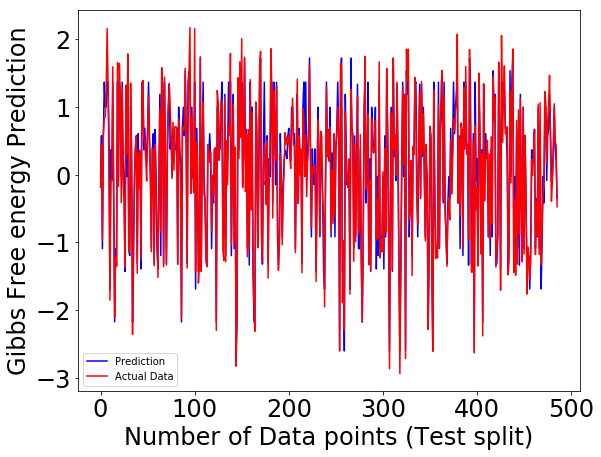

In [6]:
test_data = torch.FloatTensor(np.array(X_test))

x_test =  Variable(test_data)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test
fig1 = plt.figure(figsize=(9,7))

plt.plot(range(0,len(y1_pred)),y1_pred,c='b')
plt.plot(range(0,len(y1)),y1,c='r')
plt.legend(['Prediction','Actual Data'])

plt.xlabel('Number of Data points (Test split)', fontsize=24)
plt.ylabel('Gibbs Free energy Prediction', fontsize=24)
plt.tick_params(labelsize=24)

print ('The RMSE for the data is : {0:1.4f}'.format(np.std(y1_pred-y1)))
print ('The MAE for the data is : {0:1.4f}'.format(np.std(abs(y1_pred-y1))))


### 2. Using only one key feature from the feature matrix and evaluating the performance

#### Using only coordination number as the feature matrix

In [7]:
###########Using only coordination number 

r,c,d=FV.shape

FV_coordination = FV[2,:,:]

###with test train split

X_train_co, X_test_co, y_train_co, y_test_co = train_test_split(FV_coordination.T, DGOH.T, test_size=0.3, random_state=42,shuffle=True)





In [8]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train_co))
dg = np.array(y_train_co)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size (1),hidden layer size (2) output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 18, 18,16,18, 1, 20



# Creating a model with 2 hidden layer
model = nn.Sequential(nn.Linear(n_in, n_h1, bias = True),nn.ReLU(),nn.Linear(n_h1, n_h2, bias =False),
                     nn.ReLU(),nn.Linear(n_h2, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  1.233940601348877
epoch:  1000  loss:  0.0573035404086113
epoch:  2000  loss:  0.0531320683658123
epoch:  3000  loss:  0.053128741681575775
epoch:  4000  loss:  0.05312264710664749
epoch:  5000  loss:  0.0562622994184494
epoch:  6000  loss:  0.053166043013334274
epoch:  7000  loss:  0.05312255024909973
epoch:  8000  loss:  0.05312265455722809
epoch:  9000  loss:  0.05315401405096054


The RMSE for the data is : 0.2515
The MAE for the data is : 0.1672


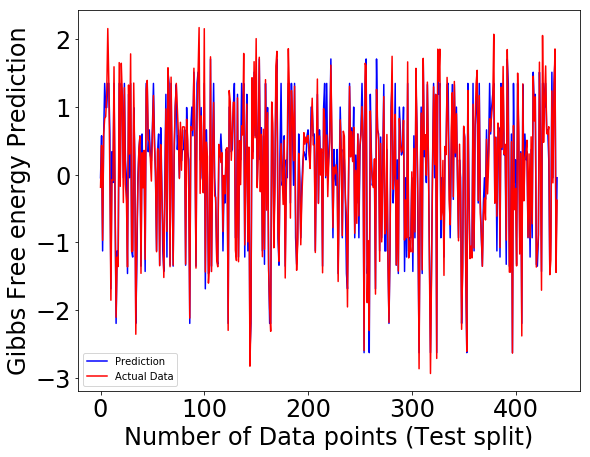

In [9]:
test_data = torch.FloatTensor(np.array(X_test_co))

x_test =  Variable(test_data)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test_co

fig1 = plt.figure(figsize=(9,7))

plt.plot(range(0,len(y1_pred)),y1_pred,c='b')
plt.plot(range(0,len(y1)),y1,c='r')
plt.legend(['Prediction','Actual Data'])

plt.xlabel('Number of Data points (Test split)', fontsize=24)
plt.ylabel('Gibbs Free energy Prediction', fontsize=24)
plt.tick_params(labelsize=24)

print ('The RMSE for the data is : {0:1.4f}'.format(np.std(y1_pred-y1)))
print ('The MAE for the data is : {0:1.4f}'.format(np.std(abs(y1_pred-y1))))


### 3. Deviation from the concept of unified model for transition metal suphides and creating a model for CoS alone

In [10]:
#######only one compound at a time CoS


###considering all the features


r,c,d=FV1.shape


FV1_reshape = FV1.reshape((r*c,d))

###with test train split

X_train_Cob, X_test_Cob, y_train_Cob, y_test_Cob = train_test_split(FV1_reshape.T, vec_Co_reshape, test_size=0.2, random_state=42,shuffle=True)

In [11]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train_Cob))
dg = np.array(y_train_Cob)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size (1),hidden layer size (2) output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 20



# Creating a model with 2 hidden layer
model = nn.Sequential(nn.Linear(n_in, n_h1, bias = True),nn.ReLU(),nn.Linear(n_h1, n_h2, bias =False),
                     nn.ReLU(),nn.Linear(n_h2, n_out))



# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(3000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  1.5595817565917969
epoch:  1000  loss:  0.04967968538403511
epoch:  2000  loss:  0.04967968538403511


The RMSE for the data is : 0.2198
The MAE for the data is : 0.1442


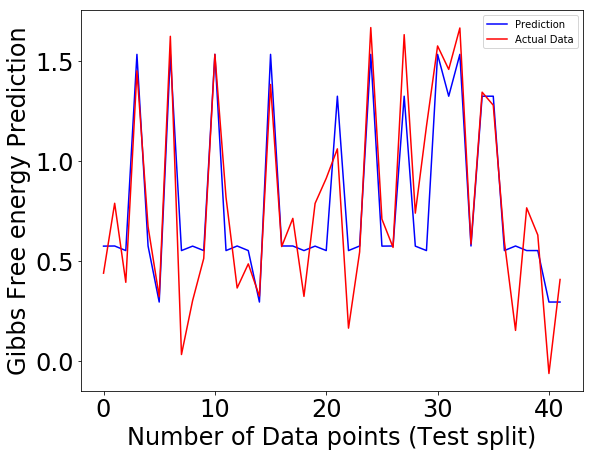

In [12]:
test_data = torch.FloatTensor(np.array(X_test_Cob))

x_test =  Variable(test_data)
y_pred_test = model(test_data)

y1_pred = y_pred_test.detach().numpy()
y1  = y_test_Cob



fig1 = plt.figure(figsize=(9,7))
plt.plot(range(0,len(y1_pred)),y1_pred,c='b')
plt.plot(range(0,len(y1)),y1,c ='r')
plt.legend(['Prediction','Actual Data'])


plt.legend(['Prediction','Actual Data'])

plt.xlabel('Number of Data points (Test split)', fontsize=24)
plt.ylabel('Gibbs Free energy Prediction', fontsize=24)
plt.tick_params(labelsize=24)

print ('The RMSE for the data is : {0:1.4f}'.format(np.std(y1_pred-y1)))
print ('The MAE for the data is : {0:1.4f}'.format(np.std(abs(y1_pred-y1))))


### 4. Normalizing the input feature matrix and evaluating the performance

In [13]:
###normalizing the input data

r,c,d=FV.shape

#reshaping data for providing input
FV_reshape = FV.reshape((r*c,d))

#nomalizing the input matrix

for i in range(0,r*c):
    FV_reshape[:,i] = (FV_reshape[:,i] - np.mean(FV_reshape[:,i]))/np.std(FV_reshape[:,i])


###creating test train split

X_train, X_test, y_train, y_test = train_test_split(FV_reshape.T, DGOH.T, test_size=0.33, random_state=42,shuffle= True)

In [14]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train))
dg = np.array(y_train)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

###neural network


# Defining input size, hidden layer size (1),hidden layer size (2) output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 20


# Creating a model with 2 hidden layer
model = nn.Sequential(nn.Linear(n_in, n_h1, bias = True),nn.ReLU(),nn.Linear(n_h1, n_h2, bias =False),
                     nn.ReLU(),nn.Linear(n_h2, n_out))



# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  1.4826411008834839
epoch:  1000  loss:  0.058497413992881775
epoch:  2000  loss:  0.0540267750620842
epoch:  3000  loss:  0.05364792048931122
epoch:  4000  loss:  0.05346584692597389
epoch:  5000  loss:  0.053456179797649384
epoch:  6000  loss:  0.05345618352293968
epoch:  7000  loss:  0.053456295281648636
epoch:  8000  loss:  0.05345972254872322
epoch:  9000  loss:  0.05345707759261131


The RMSE for the data is : 0.2488
The MAE for the data is : 0.1646


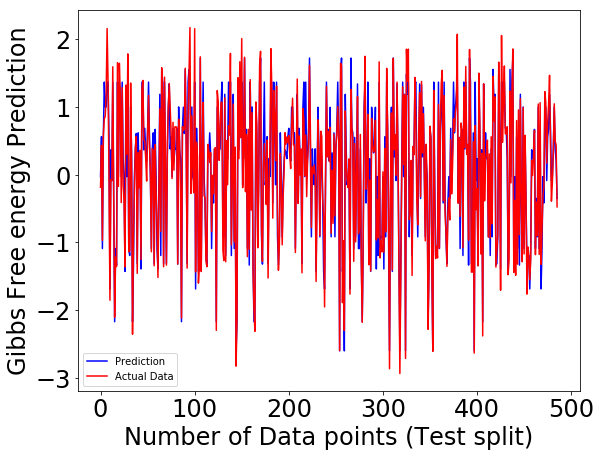

In [15]:
test_data = torch.FloatTensor(np.array(X_test))

x_test =  Variable(test_data)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test



fig1 = plt.figure(figsize=(9,7))
plt.plot(range(0,len(y1_pred)),y1_pred,c='b')
plt.plot(range(0,len(y1)),y1,c ='r')
plt.legend(['Prediction','Actual Data'])


plt.legend(['Prediction','Actual Data'])

plt.xlabel('Number of Data points (Test split)', fontsize=24)
plt.ylabel('Gibbs Free energy Prediction', fontsize=24)
plt.tick_params(labelsize=24)

print ('The RMSE for the data is : {0:1.4f}'.format(np.std(y1_pred-y1)))
print ('The MAE for the data is : {0:1.4f}'.format(np.std(abs(y1_pred-y1))))

### 5. Normalizing the input feature matrix along with output vector and evaluating the performace

In [16]:
r,c,d=FV.shape

FV_reshape = FV.reshape((r*c,d))

FV_reshape = FV_reshape.T


#normalizing the the input x parameters 
for i in range(0,r*c):
    FV_reshape[:,i] = (FV_reshape[:,i] - np.mean(FV_reshape[:,i]))/np.std(FV_reshape[:,i])

#normalizing the Gibbs free energy values    
DGOH = (DGOH - np.mean(DGOH))/np.std(DGOH)

###creating the test train split

X_train, X_test, y_train, y_test = train_test_split(FV_reshape, DGOH.T, test_size=0.33, random_state=42,shuffle= True)

epoch:  0  loss:  1.0789490938186646
epoch:  1000  loss:  0.04618232697248459


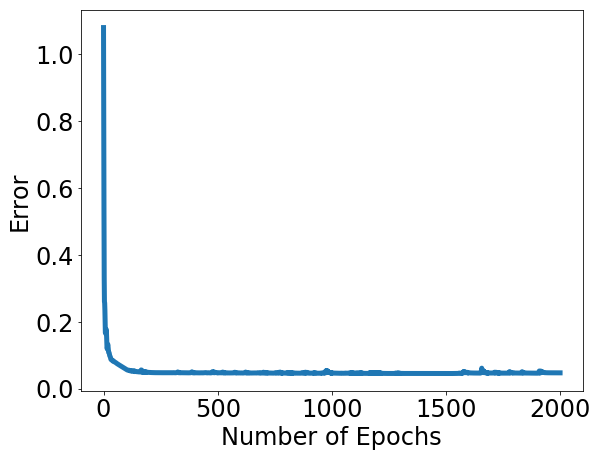

In [17]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train))
dg = np.array(y_train)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size (1),hidden layer size (2) output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 1000


# Creating a model with 2 hidden layer
model = nn.Sequential(nn.Linear(n_in, n_h1, bias = True),nn.ReLU(),nn.Linear(n_h1, n_h2, bias =False),
                     nn.ReLU(),nn.Linear(n_h2, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,eps=1e-08, weight_decay=0)
loss1 = []
# Gradient Descent
for epoch in range(2000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    loss1.append(loss)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())
        

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

    
fig1 = plt.figure(figsize=(9,7))
plt.plot(range(0,len(loss1)),loss1, lw=5)
plt.ylabel('Error', fontsize=24)
plt.xlabel('Number of Epochs', fontsize=24)
plt.tick_params(labelsize=24)

plt.savefig('Neural Net convergence plot.png', dpi=1200) 
    
plt.show()
    
        

The RMSE for the data is : 0.2336
The MAE for the data is : 0.1557


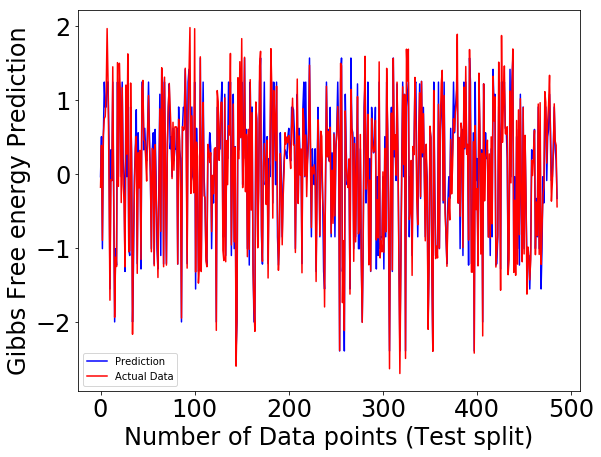

In [18]:
X_test = torch.FloatTensor(np.array(X_test))

test_data =  Variable(X_test)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test


fig1 = plt.figure(figsize=(9,7))
plt.plot(range(0,len(y1_pred)),y1_pred,c='b')
plt.plot(range(0,len(y1)),y1,c ='r')
plt.legend(['Prediction','Actual Data'])


plt.legend(['Prediction','Actual Data'])

plt.xlabel('Number of Data points (Test split)', fontsize=24)
plt.ylabel('Gibbs Free energy Prediction', fontsize=24)
plt.tick_params(labelsize=24)

print ('The RMSE for the data is : {0:1.4f}'.format(np.std(y1_pred-y1)))
print ('The MAE for the data is : {0:1.4f}'.format(np.std(abs(y1_pred-y1))))

plt.show()






### It can be seen that the neural network implementation with the input matrix and output matrix normalized gives the best accuracy

## Parity plot for the best neural network implementation with transition metal suphide class coloring for the best Neural Network implementation - Done Above

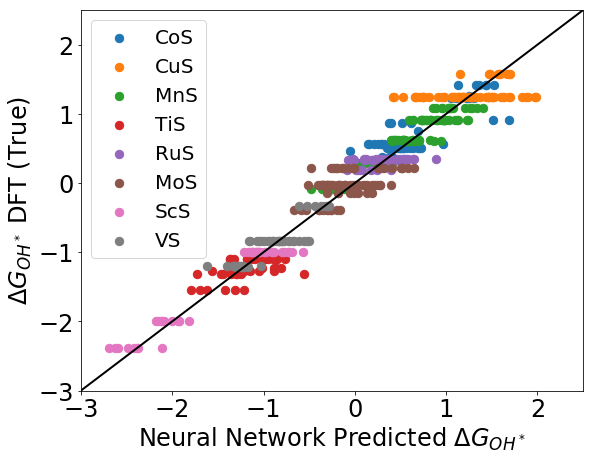

In [19]:
## Constructing index vector where the index corresponds to the corresponding M-S class

len_vec=[210,180,240,180,150,210,120,180]
len_vec_cum=np.cumsum(len_vec)
index=np.zeros((len(y1),1))
for i in range(len(y1)):
    pos=(list(DGOH.T)).index(y1[i])
    for j in range(len(len_vec_cum)):
        if pos<len_vec_cum[j]:
            index[i]=j
            break

# Index vector construction done
# Plotting different colors starts here

y1_CoS=[]
y1_CuS=[]
y1_MnS=[]
y1_TiS=[]
y1_RuS=[]
y1_MoS=[]
y1_ScS=[]
y1_VS=[]

yp_CoS=[]
yp_CuS=[]
yp_MnS=[]
yp_TiS=[]
yp_RuS=[]
yp_MoS=[]
yp_ScS=[]
yp_VS=[]
yp=y1_pred

for i in range(len(y1)):
    if index[i]==0:
        y1_CoS.append(y1[i])
        yp_CoS.append(yp[i])
    if index[i]==1:
        y1_CuS.append(y1[i])
        yp_CuS.append(yp[i])
    if index[i]==2:
        y1_MnS.append(y1[i])
        yp_MnS.append(yp[i])
    if index[i]==3:
        y1_TiS.append(y1[i])
        yp_TiS.append(yp[i])
    if index[i]==4:
        y1_RuS.append(y1[i])
        yp_RuS.append(yp[i])
    if index[i]==5:
        y1_MoS.append(y1[i])
        yp_MoS.append(yp[i])
    if index[i]==6:
        y1_ScS.append(y1[i])
        yp_ScS.append(yp[i])
    if index[i]==7:
        y1_VS.append(y1[i])
        yp_VS.append(yp[i])
        
fig1 = plt.figure(figsize=(9,7))

plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('Neural Network Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)

plt.scatter( y1_CoS,yp_CoS,s=70,label='CoS')
plt.scatter( y1_CuS,yp_CuS, s=70,label='CuS')
plt.scatter( y1_MnS,yp_MnS, s=70,label='MnS')
plt.scatter(y1_TiS, yp_TiS,  s=70,label='TiS')
plt.scatter(  y1_RuS, yp_RuS,s=70,label='RuS')
plt.scatter(y1_MoS,yp_MoS,  s=70,label='MoS')
plt.scatter( y1_ScS, yp_ScS, s=70,label='ScS')
plt.scatter(y1_VS,yp_VS,   s=70,label='VS')
plt.legend(prop={'size':20})


        
start=-3
end=2.5
plt.xlim([start,end])
plt.ylim([start,end])
p1=[start,end]
p2=[start,end]
plt.plot(p1,p2,c='black', lw='2', ls='-')
#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('Neural Network Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)

plt.savefig('Neural Net_plot.png', dpi=1200) 

## 3. KNN implementation for individual transition metal suphides and comparision

### Loading the input vector and true output vector for training and testing using KNN method

In [20]:
r,c,d=FV1.shape


FV1_reshape = FV1.reshape((r*c,d))
r,c,d=FV2.shape
FV2_reshape = FV2.reshape((r*c,d))
r,c,d=FV3.shape
FV3_reshape = FV3.reshape((r*c,d))
r,c,d=FV4.shape
FV4_reshape = FV4.reshape((r*c,d))
r,c,d=FV5.shape
FV5_reshape = FV5.reshape((r*c,d))
r,c,d=FV6.shape
FV6_reshape = FV6.reshape((r*c,d))
r,c,d=FV7.shape
FV7_reshape = FV7.reshape((r*c,d))
r,c,d=FV8.shape
FV8_reshape = FV8.reshape((r*c,d))


###with test train split

X_train_Cob, X_test_Cob, y_train_Cob, y_test_Cob = train_test_split(FV1_reshape.T, vec_Co_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Cub, X_test_Cub, y_train_Cub, y_test_Cub = train_test_split(FV2_reshape.T, vec_Cu_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Mn, X_test_Mn, y_train_Mn, y_test_Mn = train_test_split(FV3_reshape.T, vec_Mn_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Ti, X_test_Ti, y_train_Ti, y_test_Ti = train_test_split(FV4_reshape.T, vec_Ti_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Ru, X_test_Ru, y_train_Ru, y_test_Ru = train_test_split(FV5_reshape.T, vec_Ru_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Mo, X_test_Mo, y_train_Mo, y_test_Mo = train_test_split(FV6_reshape.T, vec_Mo_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Sc, X_test_Sc, y_train_Sc, y_test_Sc = train_test_split(FV7_reshape.T, vec_Sc_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_V, X_test_V, y_train_V, y_test_V = train_test_split(FV8_reshape.T, vec_V_reshape, test_size=0.2, random_state=42,shuffle=True)

In [21]:
from sklearn import neighbors

#fit model using KNN algorithm

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Cob, y_train_Cob)
y_pred_Cob = knn.predict(X_test_Cob)
y1_Cob  = y_test_Cob

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Cub, y_train_Cub)
y_pred_Cub = knn.predict(X_test_Cub)
y1_Cub  = y_test_Cub

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Mn, y_train_Mn)
y_pred_Mn = knn.predict(X_test_Mn)
y1_Mn  = y_test_Mn

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Mo, y_train_Mo)
y_pred_Mo = knn.predict(X_test_Mo)
y1_Mo  = y_test_Mo

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Ru, y_train_Ru)
y_pred_Ru = knn.predict(X_test_Ru)
y1_Ru  = y_test_Ru

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Sc, y_train_Sc)
y_pred_Sc = knn.predict(X_test_Sc)
y1_Sc  = y_test_Sc

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Ti, y_train_Ti)
y_pred_Ti = knn.predict(X_test_Ti)
y1_Ti  = y_test_Ti

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_V, y_train_V)
y_pred_V = knn.predict(X_test_V)
y1_V  = y_test_V


The MAE and RSME of CoS is 0.1742 and 0.2281
The MAE and RSME of CuS is 0.3674 and 0.4369
The MAE and RSME of MnS is 0.1410 and 0.1675
The MAE and RSME of TiS is 0.2013 and 0.2346
The MAE and RSME of RuS is 0.1702 and 0.2050
The MAE and RSME of MoS is 0.2315 and 0.3028
The MAE and RSME of ScS is 0.1457 and 0.1939
The MAE and RSME of VS is 0.1088 and 0.1298
Cross Validation = [0.94704519 0.94790419 0.93954138 0.95249142 0.94001716 0.9587681
 0.92737815 0.95626727 0.95856694 0.935859  ]
The overall MAE of the data with separate classifier for each class is 0.1932
The overall RMSE of the data with separate classifier for each class is 0.2569


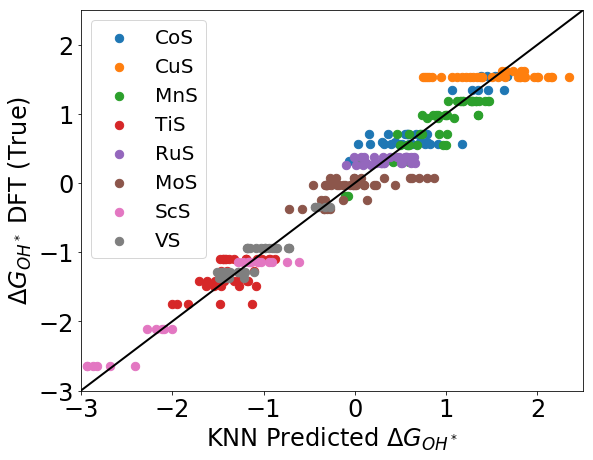

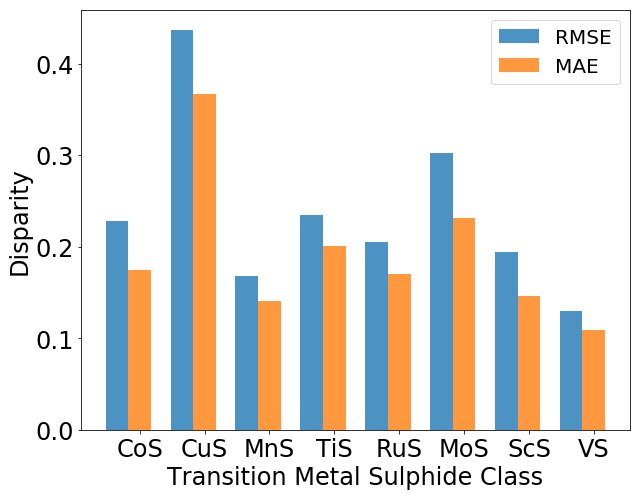

In [22]:
#printing the solution RMSE and MAE values


print ('The MAE and RSME of CoS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Cob-y_pred_Cob)), np.std(y1_Cob-y_pred_Cob)))
print ('The MAE and RSME of CuS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Cub-y_pred_Cub)), np.std(y1_Cub-y_pred_Cub)))
print ('The MAE and RSME of MnS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Mn-y_pred_Mn)), np.std(y1_Mn-y_pred_Mn)))
print ('The MAE and RSME of TiS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Ti-y_pred_Ti)), np.std(y1_Ti-y_pred_Ti)))
print ('The MAE and RSME of RuS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Ru-y_pred_Ru)), np.std(y1_Ru-y_pred_Ru)))
print ('The MAE and RSME of MoS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Mo-y_pred_Mo)), np.std(y1_Mo-y_pred_Mo)))
print ('The MAE and RSME of ScS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Sc-y_pred_Sc)), np.std(y1_Sc-y_pred_Sc)))
print ('The MAE and RSME of VS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_V-y_pred_V)), np.std(y1_V-y_pred_V)))


#plotting a parity plot for the new data 

fig1 = plt.figure(figsize=(9,7))
plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('Neural Network Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)

plt.scatter( y1_Cob,y_pred_Cob, s=70,label='CoS')
plt.scatter( y1_Cub,y_pred_Cub, s=70,label='CuS')
plt.scatter( y1_Mn,y_pred_Mn, s=70,label='MnS')
plt.scatter( y1_Ti,y_pred_Ti, s=70,label='TiS')
plt.scatter( y1_Ru,y_pred_Ru, s=70,label='RuS')
plt.scatter( y1_Mo,y_pred_Mo, s=70,label='MoS')
plt.scatter( y1_Sc,y_pred_Sc, s=70,label='ScS')
plt.scatter( y1_V,y_pred_V, s=70,label='VS')
plt.legend()
plt.legend(prop={'size':20})


start=-3
end=2.5
plt.xlim([start,end])
plt.ylim([start,end])
p1=[start,end]
p2=[start,end]
plt.plot(p1,p2,c='black', lw='2', ls='-')
#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('KNN Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)




from sklearn.model_selection import cross_val_score
CV = cross_val_score(knn, X_train, y_train, cv=10)
print('Cross Validation =',CV)
plt.savefig('KNN individual compound Accuracy plot.png', dpi=1200) 

import matplotlib.pyplot as plt
 
    
    
Co_RMSE = np.std(y1_Cob-y_pred_Cob)
CuS_RMSE = np.std(y1_Cub-y_pred_Cub)
Mn_RMSE = np.std(y1_Mn-y_pred_Mn)
Ti_RMSE =  np.std(y1_Ti-y_pred_Ti)
Ru_RMSE =  np.std(y1_Ru-y_pred_Ru)
Mo_RMSE = np.std(y1_Mo-y_pred_Mo)
Sc_RMSE = np.std(y1_Sc-y_pred_Sc)
V_RMSE = np.std(y1_V-y_pred_V)


Co_MAE = np.mean(abs(y1_Cob-y_pred_Cob))
CuS_MAE = np.mean(abs(y1_Cub-y_pred_Cub))
Mn_MAE = np.mean(abs(y1_Mn-y_pred_Mn))
Ti_MAE =  np.mean(abs(y1_Ti-y_pred_Ti))
Ru_MAE =  np.mean(abs(y1_Ru-y_pred_Ru))
Mo_MAE = np.mean(abs(y1_Mo-y_pred_Mo))
Sc_MAE = np.mean(abs(y1_Sc-y_pred_Sc))
V_MAE = np.mean(abs(y1_V-y_pred_V))


#computing the overall RMSE and MAE values for printing

y_pred_1 = np.vstack((y_pred_Cob, y_pred_Cub, y_pred_Mn, y_pred_Ti, y_pred_Mo, y_pred_Ru, y_pred_Sc,  y_pred_V))
y_pred_1= np.ravel(y_pred_1)
y1_1 = np.vstack((y1_Cob, y1_Cub, y1_Mn, y1_Ti, y1_Mo, y1_Ru, y1_Sc,  y1_V))
y1_1= np.ravel(y1_1)



Overall_MAE = np.mean(abs(y1_1-y_pred_1))
Overall_RMSE = np.std(y1_1-y_pred_1)   

print ('The overall MAE of the data with separate classifier for each class is {0:1.4f}'.format(Overall_MAE))
print ('The overall RMSE of the data with separate classifier for each class is {0:1.4f}'.format(Overall_RMSE))



#####Bar chart comparing the RMSE and MAE for each transition metal sulphide 


n_groups = 8
RMSE = (Co_RMSE, CuS_RMSE, Mn_RMSE, Ti_RMSE, Ru_RMSE, Mo_RMSE, Sc_RMSE, V_RMSE)
MAE = (Co_MAE, CuS_MAE, Mn_MAE, Ti_MAE, Ru_MAE, Mo_MAE, Sc_MAE, V_MAE)
 
# create plot
fig, ax = plt.subplots(figsize=(9,7))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, RMSE, bar_width,
                 alpha=opacity,
                   label='RMSE')
 
rects2 = plt.bar(index + bar_width, MAE, bar_width,
                 alpha=opacity,

                 label='MAE')
 

plt.xlabel('Transition Metal Sulphide Class', fontsize=24)
plt.ylabel('Disparity', fontsize=24)



plt.xticks(index + bar_width, ('CoS', 'CuS', 'MnS', 'TiS','RuS','MoS','ScS','VS'))
plt.legend(prop={'size':20})
plt.tick_params(labelsize=24)

 
plt.tight_layout()

plt.savefig('RMSE and MAE plot for various sulphides.png', dpi=1200) 


## 4. Neural Net implementation for individual transition metal suphides and comparision

### Loading the input vector and true output vector for training and testing using Neural Net

In [23]:
r,c,d=FV1.shape


FV1_reshape = FV1.reshape((r*c,d))
r,c,d=FV2.shape
FV2_reshape = FV2.reshape((r*c,d))
r,c,d=FV3.shape
FV3_reshape = FV3.reshape((r*c,d))
r,c,d=FV4.shape
FV4_reshape = FV4.reshape((r*c,d))
r,c,d=FV5.shape
FV5_reshape = FV5.reshape((r*c,d))
r,c,d=FV6.shape
FV6_reshape = FV6.reshape((r*c,d))
r,c,d=FV7.shape
FV7_reshape = FV7.reshape((r*c,d))
r,c,d=FV8.shape
FV8_reshape = FV8.reshape((r*c,d))


###with test train split

X_train_Cob, X_test_Cob, y_train_Cob, y_test_Cob = train_test_split(FV1_reshape.T, vec_Co_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Cub, X_test_Cub, y_train_Cub, y_test_Cub = train_test_split(FV2_reshape.T, vec_Cu_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Mn, X_test_Mn, y_train_Mn, y_test_Mn = train_test_split(FV3_reshape.T, vec_Mn_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Ti, X_test_Ti, y_train_Ti, y_test_Ti = train_test_split(FV4_reshape.T, vec_Ti_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Ru, X_test_Ru, y_train_Ru, y_test_Ru = train_test_split(FV5_reshape.T, vec_Ru_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Mo, X_test_Mo, y_train_Mo, y_test_Mo = train_test_split(FV6_reshape.T, vec_Mo_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Sc, X_test_Sc, y_train_Sc, y_test_Sc = train_test_split(FV7_reshape.T, vec_Sc_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_V, X_test_V, y_train_V, y_test_V = train_test_split(FV8_reshape.T, vec_V_reshape, test_size=0.2, random_state=42,shuffle=True)

In [24]:
from sklearn import neighbors
######################################################

# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

def neural_net(x,y,X_test):

    #######neural network


    # Defining input size, hidden layer size (1),hidden layer size (2) output size and batch size respectively
    n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 1000


    # Creating a model with 2 hidden layer
    model = nn.Sequential(nn.Linear(n_in, n_h1, bias = True),nn.ReLU(),nn.Linear(n_h1, n_h2, bias =False),
                         nn.ReLU(),nn.Linear(n_h2, n_out))


    # Construct the loss function
    criterion = torch.nn.MSELoss()

    # Construct the optimizer (Stochastic Gradient Descent in this case)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01,eps=1e-08, weight_decay=0)
    loss1 = []
    # Gradient Descent
    for epoch in range(2000):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x)
        # Compute and print loss
        loss = criterion(y_pred, y)
        loss1.append(loss)
        if epoch%1000 == 0:
            print('epoch: ', epoch,' loss: ', loss.item())


        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
                
    X_test = torch.FloatTensor(np.array(X_test))

    test_data =  Variable(X_test)
    y_pred_test = model(test_data)
    y1_pred = y_pred_test.detach().numpy()
    return y1_pred



########
train_data = torch.FloatTensor(np.array(X_train_Cob))
dg = np.array(y_train_Cob)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

y1_pred_Cob = neural_net(x,y,X_test_Cob)

y1_Cob  = y_test_Cob

####################

train_data = torch.FloatTensor(np.array(X_train_Cub))
dg = np.array(y_train_Cub)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

y1_pred_Cub = neural_net(x,y,X_test_Cub)

y1_Cub  = y_test_Cub

################

train_data = torch.FloatTensor(np.array(X_train_Mn))
dg = np.array(y_train_Mn)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

y1_pred_Mn = neural_net(x,y,X_test_Mn)

y1_Mn  = y_test_Mn

################

train_data = torch.FloatTensor(np.array(X_train_Ti))
dg = np.array(y_train_Ti)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

y1_pred_Ti = neural_net(x,y,X_test_Ti)

y1_Ti  = y_test_Ti

################

train_data = torch.FloatTensor(np.array(X_train_Ru))
dg = np.array(y_train_Ru)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

y1_pred_Ru = neural_net(x,y,X_test_Ru)

y1_Ru  = y_test_Ru

################

train_data = torch.FloatTensor(np.array(X_train_Mo))
dg = np.array(y_train_Mo)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

y1_pred_Mo = neural_net(x,y,X_test_Mo)

y1_Mo  = y_test_Mo

################

train_data = torch.FloatTensor(np.array(X_train_Sc))
dg = np.array(y_train_Sc)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

y1_pred_Sc = neural_net(x,y,X_test_Sc)

y1_Sc  = y_test_Sc

################

train_data = torch.FloatTensor(np.array(X_train_V))
dg = np.array(y_train_V)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

y1_pred_V = neural_net(x,y,X_test_V)

y1_V  = y_test_V






epoch:  0  loss:  0.2654978036880493
epoch:  1000  loss:  0.04970014840364456
epoch:  0  loss:  0.6737924218177795
epoch:  1000  loss:  0.14306414127349854
epoch:  0  loss:  0.24555091559886932
epoch:  1000  loss:  0.02460521087050438
epoch:  0  loss:  2.4700920581817627
epoch:  1000  loss:  0.045346345752477646
epoch:  0  loss:  0.16726461052894592
epoch:  1000  loss:  0.036850735545158386
epoch:  0  loss:  0.12078044563531876
epoch:  1000  loss:  0.0764063373208046
epoch:  0  loss:  1.9920743703842163
epoch:  1000  loss:  0.03228045627474785
epoch:  0  loss:  2.00192928314209
epoch:  1000  loss:  0.027414044365286827


The MAE and RSME of CoS is 0.1742 and 0.2281
The MAE and RSME of CuS is 0.3674 and 0.4369
The MAE and RSME of MnS is 0.1410 and 0.1675
The MAE and RSME of TiS is 0.2013 and 0.2346
The MAE and RSME of RuS is 0.1702 and 0.2050
The MAE and RSME of MoS is 0.2315 and 0.3028
The MAE and RSME of ScS is 0.1457 and 0.1939
The MAE and RSME of VS is 0.1088 and 0.1298
Cross Validation = [0.94704519 0.94790419 0.93954138 0.95249142 0.94001716 0.9587681
 0.92737815 0.95626727 0.95856694 0.935859  ]
The overall MAE of the data with separate classifier for each class is 0.1932
The overall RMSE of the data with separate classifier for each class is 0.2569


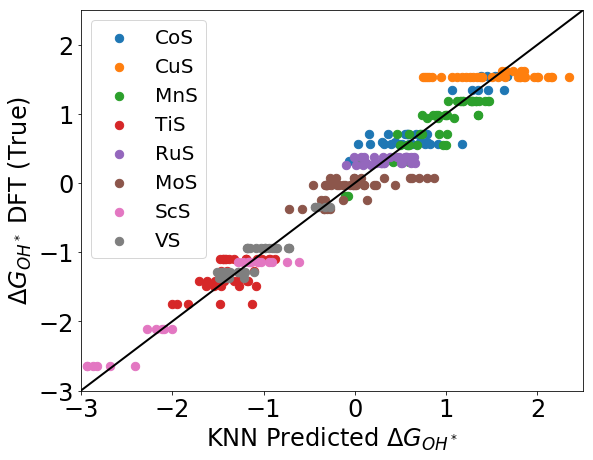

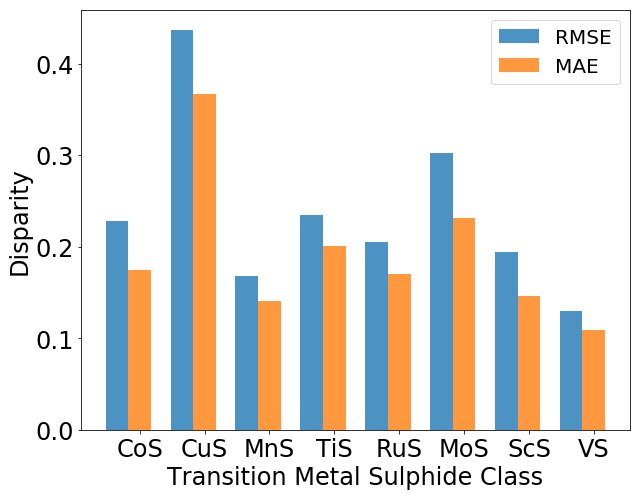

In [26]:
#printing the solution RMSE and MAE values


print ('The MAE and RSME of CoS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Cob-y_pred_Cob)), np.std(y1_Cob-y_pred_Cob)))
print ('The MAE and RSME of CuS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Cub-y_pred_Cub)), np.std(y1_Cub-y_pred_Cub)))
print ('The MAE and RSME of MnS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Mn-y_pred_Mn)), np.std(y1_Mn-y_pred_Mn)))
print ('The MAE and RSME of TiS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Ti-y_pred_Ti)), np.std(y1_Ti-y_pred_Ti)))
print ('The MAE and RSME of RuS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Ru-y_pred_Ru)), np.std(y1_Ru-y_pred_Ru)))
print ('The MAE and RSME of MoS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Mo-y_pred_Mo)), np.std(y1_Mo-y_pred_Mo)))
print ('The MAE and RSME of ScS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_Sc-y_pred_Sc)), np.std(y1_Sc-y_pred_Sc)))
print ('The MAE and RSME of VS is {0:1.4f} and {1:1.4f}'.format(np.mean(abs(y1_V-y_pred_V)), np.std(y1_V-y_pred_V)))


#plotting a parity plot for the new data 

fig1 = plt.figure(figsize=(9,7))
plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('Neural Network Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)

plt.scatter( y1_Cob,y_pred_Cob, s=70,label='CoS')
plt.scatter( y1_Cub,y_pred_Cub, s=70,label='CuS')
plt.scatter( y1_Mn,y_pred_Mn, s=70,label='MnS')
plt.scatter( y1_Ti,y_pred_Ti, s=70,label='TiS')
plt.scatter( y1_Ru,y_pred_Ru, s=70,label='RuS')
plt.scatter( y1_Mo,y_pred_Mo, s=70,label='MoS')
plt.scatter( y1_Sc,y_pred_Sc, s=70,label='ScS')
plt.scatter( y1_V,y_pred_V, s=70,label='VS')
plt.legend()
plt.legend(prop={'size':20})


start=-3
end=2.5
plt.xlim([start,end])
plt.ylim([start,end])
p1=[start,end]
p2=[start,end]
plt.plot(p1,p2,c='black', lw='2', ls='-')
#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('KNN Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)




from sklearn.model_selection import cross_val_score
CV = cross_val_score(knn, X_train, y_train, cv=10)
print('Cross Validation =',CV)
plt.savefig('KNN individual compound Accuracy plot.png', dpi=1200) 

import matplotlib.pyplot as plt
 
    
    
Co_RMSE = np.std(y1_Cob-y_pred_Cob)
CuS_RMSE = np.std(y1_Cub-y_pred_Cub)
Mn_RMSE = np.std(y1_Mn-y_pred_Mn)
Ti_RMSE =  np.std(y1_Ti-y_pred_Ti)
Ru_RMSE =  np.std(y1_Ru-y_pred_Ru)
Mo_RMSE = np.std(y1_Mo-y_pred_Mo)
Sc_RMSE = np.std(y1_Sc-y_pred_Sc)
V_RMSE = np.std(y1_V-y_pred_V)


Co_MAE = np.mean(abs(y1_Cob-y_pred_Cob))
CuS_MAE = np.mean(abs(y1_Cub-y_pred_Cub))
Mn_MAE = np.mean(abs(y1_Mn-y_pred_Mn))
Ti_MAE =  np.mean(abs(y1_Ti-y_pred_Ti))
Ru_MAE =  np.mean(abs(y1_Ru-y_pred_Ru))
Mo_MAE = np.mean(abs(y1_Mo-y_pred_Mo))
Sc_MAE = np.mean(abs(y1_Sc-y_pred_Sc))
V_MAE = np.mean(abs(y1_V-y_pred_V))


#computing the overall RMSE and MAE values for printing

y_pred_1 = np.vstack((y_pred_Cob, y_pred_Cub, y_pred_Mn, y_pred_Ti, y_pred_Mo, y_pred_Ru, y_pred_Sc,  y_pred_V))
y_pred_1= np.ravel(y_pred_1)
y1_1 = np.vstack((y1_Cob, y1_Cub, y1_Mn, y1_Ti, y1_Mo, y1_Ru, y1_Sc,  y1_V))
y1_1= np.ravel(y1_1)



Overall_MAE = np.mean(abs(y1_1-y_pred_1))
Overall_RMSE = np.std(y1_1-y_pred_1)   

print ('The overall MAE of the data with separate classifier for each class is {0:1.4f}'.format(Overall_MAE))
print ('The overall RMSE of the data with separate classifier for each class is {0:1.4f}'.format(Overall_RMSE))



#####Bar chart comparing the RMSE and MAE for each transition metal sulphide 


n_groups = 8
RMSE = (Co_RMSE, CuS_RMSE, Mn_RMSE, Ti_RMSE, Ru_RMSE, Mo_RMSE, Sc_RMSE, V_RMSE)
MAE = (Co_MAE, CuS_MAE, Mn_MAE, Ti_MAE, Ru_MAE, Mo_MAE, Sc_MAE, V_MAE)
 
# create plot
fig, ax = plt.subplots(figsize=(9,7))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, RMSE, bar_width,
                 alpha=opacity,
                   label='RMSE')
 
rects2 = plt.bar(index + bar_width, MAE, bar_width,
                 alpha=opacity,

                 label='MAE')
 

plt.xlabel('Transition Metal Sulphide Class', fontsize=24)
plt.ylabel('Disparity', fontsize=24)



plt.xticks(index + bar_width, ('CoS', 'CuS', 'MnS', 'TiS','RuS','MoS','ScS','VS'))
plt.legend(prop={'size':20})
plt.tick_params(labelsize=24)

 
plt.tight_layout()

plt.savefig('RMSE and MAE plot for various sulphides -Neural Net.png', dpi=1200) 


It can be seen that both the methods (KNN and Neural Net) gave similar disparity plots